# Predictive Modelling: XGBoost

# Imports

In [11]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

# 
from IPython.display import display, clear_output
import sys
import time

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# 
from src.models.predict_model import avg_model, run_combinations
#from src.models.train_model import run_combinations 

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from atomm.Tools import calc_open_position, calc_returns
from src.visualization.visualize import plot_confusion_matrix
from atomm.Methods import BlockingTimeSeriesSplit, PurgedKFold           


import time

# scikit-learn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from xgboost import XGBClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For BayesianHyperparameter Optimization
from atomm.Models.Tuning import search_space, BayesianSearch
from hyperopt import space_eval

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
#import matplotlib.style as style
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Load environment variables
load_dotenv(find_dotenv())

True

## Loading the data

In [35]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')
data_base_dir

'./data/'

In [30]:
!pwd

/Users/robin/Documents/projects/python/capstone_nf/notebooks


In [27]:
fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
#fname = '../data/processed/index.h5'

In [28]:
# Load dataset from HDF storage
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')
    y_2c = storage.get('nyse/engineered/target_two_class')
    y_3c = storage.get('nyse/engineered/target_three_class')
    df_moments = storage.get('nyse/engineered/features')
    #print(storage.info())
    
# Create copies of the pristine data
X = df_moments.copy()
y = y_3c.copy()
y2 = y_2c.copy()
prices = djia.copy()

In [20]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']
symbol_list = df_moments.columns.get_level_values(0).unique()

NameError: name 'df_moments' is not defined

In [5]:
df_moments.columns.get_level_values(1).unique()

Index(['macd_3', 'rsi_3', 'stoc_3', 'roc_3', 'bbu_3', 'bbl_3', 'ema_3',
       'atr_3', 'adx_3', 'cci_3', 'williamsr_3', 'stocd_3', 'macd_5', 'rsi_5',
       'stoc_5', 'roc_5', 'bbu_5', 'bbl_5', 'ema_5', 'atr_5', 'adx_5', 'cci_5',
       'williamsr_5', 'stocd_5', 'macd_7', 'rsi_7', 'stoc_7', 'roc_7', 'bbu_7',
       'bbl_7', 'ema_7', 'atr_7', 'adx_7', 'cci_7', 'williamsr_7', 'stocd_7',
       'macd_10', 'rsi_10', 'stoc_10', 'roc_10', 'bbu_10', 'bbl_10', 'ema_10',
       'atr_10', 'adx_10', 'cci_10', 'williamsr_10', 'stocd_10', 'macd_15',
       'rsi_15', 'stoc_15', 'roc_15', 'bbu_15', 'bbl_15', 'ema_15', 'atr_15',
       'adx_15', 'cci_15', 'williamsr_15', 'stocd_15', 'macd_20', 'rsi_20',
       'stoc_20', 'roc_20', 'bbu_20', 'bbl_20', 'ema_20', 'atr_20', 'adx_20',
       'cci_20', 'williamsr_20', 'stocd_20', 'macd_25', 'rsi_25', 'stoc_25',
       'roc_25', 'bbu_25', 'bbl_25', 'ema_25', 'atr_25', 'adx_25', 'cci_25',
       'williamsr_25', 'stocd_25', 'macd_30', 'rsi_30', 'stoc_30', 'ro

## Imputing missing values

In [6]:
X.shape

(1954, 4800)

In [7]:
check_for_missing_vals(X)

No missing values found in dataframe


Prices values

In [8]:
prices.shape

(1954, 250)

In [9]:
check_for_missing_vals(prices)

No missing values found in dataframe


In [10]:
y_3c.shape

(1954, 450)

In [11]:
check_for_missing_vals(y_3c)

No missing values found in dataframe


In [12]:
y2.shape

(1954, 450)

In [13]:
check_for_missing_vals(y2)

No missing values found in dataframe


No missing values, and sizes of ```y.shape[0]``` and```X.shape[0]``` match.

# Scaling the features

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [15]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [16]:
scaled = scale.fit_transform(X)

In [17]:
scaled.shape

(1954, 4800)

In [18]:
#X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
X_scaled = X

# Train-Test Split

In [19]:
# Use 70/30 train/test splits
test_p = .3

In [20]:
# Scaled, three-class
test_size = int((1 - test_p) * X_scaled.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [21]:
# Unscaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X[:test_size], X[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [58]:
# Scaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [ ]:
#test_size = test_p
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

# Model

In [22]:
symbol_list

Index(['CNC', 'FMC', 'ALGN', 'RTN', 'FAST', 'ETFC', 'ABC', 'PFG', 'AXP', 'PNW',
       'CMS', 'URI', 'PRGO', 'DRI', 'MAS', 'M', 'ZION', 'CINF', 'HIG', 'EOG',
       'ICE', 'CBOE', 'ALL', 'UHS', 'FRT', 'NEM', 'BLL', 'NDAQ', 'CMG', 'JKHY',
       'T', 'QCOM', 'FTI', 'AOS', 'ATVI', 'STT', 'TXN', 'KIM', 'NTAP', 'CHD',
       'WYNN', 'GM', 'SJM', 'MCHP', 'ES', 'KMB', 'GIS', 'EXC', 'IBM', 'MSFT'],
      dtype='object')

In [23]:
symbol = 'T'
n1 = 15
n2 = 15
n_estimators = 10
# set up cross validation splits
tscv = TimeSeriesSplit(n_splits=5)
btscv = BlockingTimeSeriesSplit(n_splits=5)
#ppcv = PurgedKFold(n_splits=5)

In [24]:
# Creates a list of features for a given lookback window (n1)
features = [f'{x}_{n1}' for x in ti_list]
# Creates a list of all features
all_features = [f'{x}_{n}' for x in ti_list for n in input_window_size]

## Single lookback/lookahead combination

In [102]:
clf_svc1 = OneVsRestClassifier(
    BaggingClassifier(
                    SVC(
                        kernel='rbf',
                        class_weight='balanced'
                    ),
                    max_samples=.4, 
                    n_estimators=n_estimators,
                    n_jobs=-1)
)


clf_svc1.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])

OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=SVC(C=1.0,
                                                                   break_ties=False,
                                                                   cache_size=200,
                                                                   class_weight='balanced',
                                                                   coef0=0.0,
                                                                   decision_function_shape='ovr',
                                                                   degree=3,
                                                                   gamma='scale',
                                                                   kernel='rbf',
                                                                   max_iter=-1,
                                                                   probability=False,
                                                                   random_state=None

Accuracy Score:  0.5400340715502555
              precision    recall  f1-score   support

           0       0.91      0.52      0.66       505
           1       0.19      0.68      0.29        82

    accuracy                           0.54       587
   macro avg       0.55      0.60      0.48       587
weighted avg       0.81      0.54      0.61       587



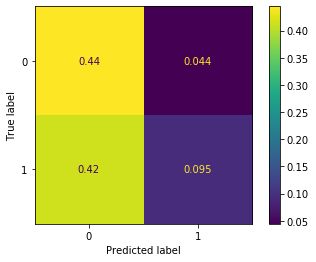

In [103]:
y_pred_svc1 = clf_svc1.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print('Accuracy Score: ', accuracy_score(y_pred_svc1, y_test[symbol][f'signal_{n}']))
print(classification_report(y_pred_svc1, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(
    clf_svc1,
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    normalize='all'
)

## All combinations

## Averaging across all 50 randomly selected stocks

In [172]:
avg_results, scores_dict, preds_dict, params_dict, returns_dict = avg_model(
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=clf_svc1,
    silent = False
)

'Leg [50/50]; Elapsed Time 337.0s\n'

,3,5,7,10,15,20,25,30
1,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
3,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
5,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
7,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
10,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
15,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
20,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
25,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
30,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535


## Hyperparamter Optimization: GridSearch

In [163]:
gsearch_xgb.best_score_

0.5876651982378854

## Hyperparamter Optimization: Bayesian Optimization

### XGBoost

In [25]:
n1=15
n2=15
symbol='T'

In [26]:
y_train[symbol][f'signal_{n2}'].value_counts()

1    724
0    643
Name: signal_15, dtype: int64

In [27]:
symbol_list

Index(['CNC', 'FMC', 'ALGN', 'RTN', 'FAST', 'ETFC', 'ABC', 'PFG', 'AXP', 'PNW',
       'CMS', 'URI', 'PRGO', 'DRI', 'MAS', 'M', 'ZION', 'CINF', 'HIG', 'EOG',
       'ICE', 'CBOE', 'ALL', 'UHS', 'FRT', 'NEM', 'BLL', 'NDAQ', 'CMG', 'JKHY',
       'T', 'QCOM', 'FTI', 'AOS', 'ATVI', 'STT', 'TXN', 'KIM', 'NTAP', 'CHD',
       'WYNN', 'GM', 'SJM', 'MCHP', 'ES', 'KMB', 'GIS', 'EXC', 'IBM', 'MSFT'],
      dtype='object')

In [28]:
# Optimizing for accuracy_score

In [32]:
model = XGBClassifier
bsearch_xgba, clf_bsearch_xgba, params_bsearch_xgba = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='accuracy_score'
)

100%|██████████| 100/100 [06:56<00:00,  4.17s/it, best loss: -0.6690909090909091] 
##### Results #####
Score best parameters:  -0.6690909090909091
Best parameters:  {'booster': 'gblinear', 'colsample_bytree': 0.36129690778665075, 'cv': 'btscv', 'gamma': 0, 'learning_rate': 73.01990167419177, 'max_depth': 103, 'model': <class 'xgboost.sklearn.XGBClassifier'>, 'n_estimators': 904, 'n_jobs': -1, 'subsample': 1}
Test Score (accuracy):  0.4565587734241908
Parameter combinations evaluated:  100
Time elapsed:  417.04670810699463


Recall Score:  0.0
              precision    recall  f1-score   support

           0       1.00      0.46      0.63       587
           1       0.00      0.00      0.00         0

    accuracy                           0.46       587
   macro avg       0.50      0.23      0.31       587
weighted avg       1.00      0.46      0.63       587



//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


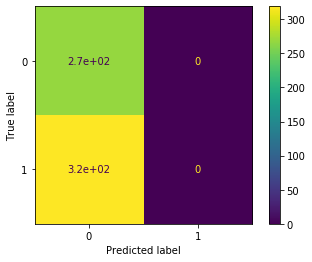

In [33]:
y_pred_bsearch_xgba = clf_bsearch_xgba.predict(X_test[symbol][features])
print('Recall Score: ', recall_score(y_pred_bsearch_xgba, y_test[symbol][f'signal_{n2}']))
print(classification_report(y_pred_bsearch_xgba, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_bsearch_xgba,
    X_test[symbol][features], y_test[symbol][f'signal_{n2}'],
)



In [44]:
calc_returns(y_pred_bsearch_xgba, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.0,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.0,-0.010550
2017-07-14 00:00:00+00:00,0.002486,0,0.0,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,0.0,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,0,0.0,0.105152
2019-11-01 00:00:00+00:00,0.011951,0,0.0,0.117103
2019-11-04 00:00:00+00:00,-0.001540,0,0.0,0.115563


In [58]:
# Optimizing for recall_score

In [35]:
model = XGBClassifier
bsearch_xgbb, clf_bsearch_xgbb, params_bsearch_xgbb = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='recall_score'
)

100%|██████████| 100/100 [04:07<00:00,  2.47s/it, best loss: -0.911648686934728]
##### Results #####
Score best parameters:  -0.911648686934728
Best parameters:  {'booster': 'gbtree', 'colsample_bytree': 0.5072711376222986, 'cv': 'tscv', 'gamma': 5, 'learning_rate': 30.882542347484573, 'max_depth': 2, 'model': <class 'xgboost.sklearn.XGBClassifier'>, 'n_estimators': 775, 'n_jobs': -1, 'subsample': 1}
Test Score (accuracy):  0.5434412265758092
Parameter combinations evaluated:  100
Time elapsed:  247.46733975410461


Recall Score:  0.5434412265758092
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70       587

    accuracy                           0.54       587
   macro avg       0.50      0.27      0.35       587
weighted avg       1.00      0.54      0.70       587



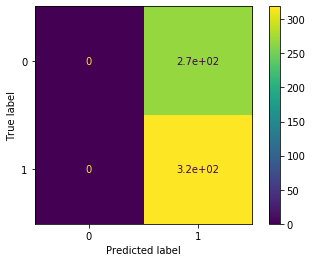

In [36]:
y_pred_bsearch_xgbb = clf_bsearch_xgbb.predict(X_test[symbol][features])
print('Recall Score: ', recall_score(y_pred_bsearch_xgbb, y_test[symbol][f'signal_{n2}']))
print(classification_report(y_pred_bsearch_xgbb, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_bsearch_xgbb,
    X_test[symbol][features], y_test[symbol][f'signal_{n2}'],
)

In [45]:
calc_returns(y_pred_bsearch_xgbb, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,1,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,1,0.006284,0.006284
2017-07-13 00:00:00+00:00,-0.016834,1,-0.010550,-0.010550
2017-07-14 00:00:00+00:00,0.002486,1,-0.008064,-0.008064
2017-07-17 00:00:00+00:00,0.002479,1,-0.005585,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.105152,0.105152
2019-11-01 00:00:00+00:00,0.011951,1,0.117103,0.117103
2019-11-04 00:00:00+00:00,-0.001540,1,0.115563,0.115563


In [64]:
# f1_score as scoring metric

In [65]:
model = XGBClassifier
bsearch_xgbc, clf_bsearch_xgbc, params_bsearch_xgbc = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='f1_score'
)

100%|██████████| 100/100 [01:24<00:00,  1.18it/s, best loss: -1.0]              
##### Results #####
Score best parameters:  -1.0
Best parameters:  {'C': 1.2684596435401332, 'cv': 'tscv', 'gamma': 4.423721243560753e-07, 'max_samples': 0.6601903887287633, 'model': <class 'sklearn.svm._classes.SVC'>, 'normalize': 0, 'scale': 1}
Test Score (accuracy):  0.5434412265758092
Parameter combinations evaluated:  100
Time elapsed:  84.97224712371826


In [47]:
y_pred_bsearch_xgbc = clf_bsearch_xgbc.predict(X_test[symbol][features])
print('Recall Score: ', recall_score(y_pred_bsearch_xgbb, y_test[symbol][f'signal_{n2}']))
print(classification_report(y_pred_bsearch_xgbc, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_bsearch_xgbc,
    X_test[symbol][features], y_test[symbol][f'signal_{n2}'],
)

NameError: name 'clf_bsearch_xgbc' is not defined

In [46]:
calc_returns(y_pred_bsearch_xgbc, djia[symbol][test_size:])

NameError: name 'y_pred_bsearch_xgbc' is not defined

In [68]:
# Precision as scoring metric

In [69]:
model = XGBClassifier
bsearch_xgbd, clf_bsearch_xgbd, params_bsearch_xgbd = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='precision_score'
)

100%|██████████| 100/100 [01:14<00:00,  1.33it/s, best loss: -0.8559006211180125]
##### Results #####
Score best parameters:  -0.8559006211180125
Best parameters:  {'C': 33.70248519605152, 'cv': 'btscv', 'gamma': 0.0013222898903965097, 'max_samples': 0.8926533257844226, 'model': <class 'sklearn.svm._classes.SVC'>, 'normalize': 1, 'scale': 1}
Test Score (accuracy):  0.5366269165247018
Parameter combinations evaluated:  100
Time elapsed:  75.24364185333252


Recall Score:  0.5685131195335277
              precision    recall  f1-score   support

           0       0.45      0.49      0.47       244
           1       0.61      0.57      0.59       343

    accuracy                           0.54       587
   macro avg       0.53      0.53      0.53       587
weighted avg       0.54      0.54      0.54       587



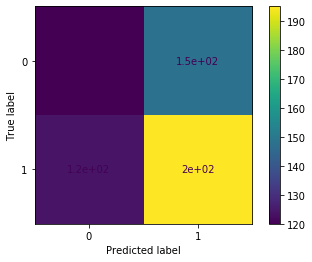

In [70]:
y_pred_bsearch_xgbd = clf_bsearch_xgbd.predict(X_test[symbol][features])
print('Recall Score: ', recall_score(y_pred_bsearch_xgbd, y_test[symbol][f'signal_{n2}']))
print(classification_report(y_pred_bsearch_xgbd, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_bsearch_xgbd,
    X_test[symbol][features], y_test[symbol][f'signal_{n2}'],
)

In [71]:
calc_returns(y_pred_bsearch_xgbd, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,1,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,1,0.006284,0.006284
2017-07-13 00:00:00+00:00,-0.016834,1,-0.010550,-0.010550
2017-07-14 00:00:00+00:00,0.002486,1,-0.008064,-0.008064
2017-07-17 00:00:00+00:00,0.002479,1,-0.005585,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.105152,0.105152
2019-11-01 00:00:00+00:00,0.011951,1,0.117103,0.117103
2019-11-04 00:00:00+00:00,-0.001540,1,0.115563,0.115563


### XGBoost with all features

In [66]:
# Accuracy as scoring metric

In [ ]:
n1=15
n2=15
symbol='T'

In [39]:
model = XGBClassifier
bsearch_xgb1, clf_bsearch_xgb1, params_bsearch_xgb1 = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][all_features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='accuracy_score'
)

  1%|          | 1/100 [00:06<11:13,  6.80s/it, best loss: -0.49378091494879806]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/xgboost/sklearn.py:800: RuntimeWarning: invalid value encountered in greater
  column_indexes[class_probs > 0.5] = 1



100%|██████████| 100/100 [12:25<00:00,  7.45s/it, best loss: -0.6290909090909091]
##### Results #####
Score best parameters:  -0.6290909090909091
Best parameters:  {'booster': 'dart', 'colsample_bytree': 0.9147920374654565, 'cv': 'btscv', 'gamma': 0, 'learning_rate': 15.935744403348682, 'max_depth': 155, 'model': <class 'xgboost.sklearn.XGBClassifier'>, 'n_estimators': 604, 'n_jobs': -1, 'subsample': 1}
Test Score (accuracy):  0.5161839863713799
Parameter combinations evaluated:  100
Time elapsed:  747.8831260204315


Accuracy Score:  0.5161839863713799
              precision    recall  f1-score   support

           0       0.37      0.46      0.41       212
           1       0.64      0.55      0.59       375

    accuracy                           0.52       587
   macro avg       0.50      0.50      0.50       587
weighted avg       0.54      0.52      0.52       587



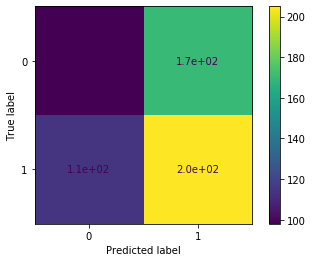

In [41]:
y_pred_xgb1 = clf_bsearch_xgb1.predict(X_test[symbol][all_features])
print('Accuracy Score: ', accuracy_score(y_pred_xgb1, y_test[symbol][f'signal_{n1}']))
print(classification_report(y_pred_xgb1, y_test[symbol][f'signal_{n1}']))
plot_confusion_matrix(
    clf_bsearch_xgb1,
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n1}'],
)



In [42]:
calc_returns(y_pred_xgb1, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.000000,0.006284
2017-07-13 00:00:00+00:00,-0.016834,1,-0.016834,-0.010550
2017-07-14 00:00:00+00:00,0.002486,1,-0.014349,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,-0.014349,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.020914,0.105152
2019-11-01 00:00:00+00:00,0.011951,0,0.020914,0.117103
2019-11-04 00:00:00+00:00,-0.001540,1,0.019374,0.115563


In [ ]:
# Recall as scoring metric

In [79]:
model = XGBClassifier
bsearch_xgb2, clf_bsearch_xgb2, params_bsearch_xgb2 = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][all_features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='recall_score'
)

100%|██████████| 100/100 [00:57<00:00,  1.75it/s, best loss: -0.6399999999999999]
##### Results #####
Score best parameters:  -0.6399999999999999
Best parameters:  {'C': 35.094482053713115, 'cv': 'btscv', 'gamma': 0.00033006568854120804, 'max_samples': 0.6965204658380075, 'model': <class 'sklearn.svm._classes.SVC'>, 'normalize': 0, 'scale': 0}
Test Score (accuracy):  0.5485519591141397
Parameter combinations evaluated:  100
Time elapsed:  57.48174428939819


In [43]:
y_pred_xgb2 = clf_bsearch_xgb2.predict(X_test[symbol][all_features])
print('Recall Score: ', recall_score(y_pred_xgb2, y_test[symbol][f'signal_{n1}']))
print(classification_report(y_pred_xgb2, y_test[symbol][f'signal_{n1}']))
plot_confusion_matrix(
    clf_bsearch_xgb2, 
    X_test[symbol][all_features], y_test[symbol][f'signal_{n1}']
)


NameError: name 'clf_bsearch_xgb2' is not defined

In [85]:
calc_returns(y_pred_xgb2, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,1,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,1,0.006284,0.006284
2017-07-13 00:00:00+00:00,-0.016834,1,-0.010550,-0.010550
2017-07-14 00:00:00+00:00,0.002486,1,-0.008064,-0.008064
2017-07-17 00:00:00+00:00,0.002479,1,-0.005585,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.105152,0.105152
2019-11-01 00:00:00+00:00,0.011951,1,0.117103,0.117103
2019-11-04 00:00:00+00:00,-0.001540,1,0.115563,0.115563


In [ ]:
# f1_score as scoring metric

In [88]:
model = XGBClassifier
bsearch_xgb3, clf_bsearch_xgb3, params_bsearch_xgb3 = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][all_features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='f1_score'
)

100%|██████████| 100/100 [01:39<00:00,  1.00it/s, best loss: -0.6290909090909091]
##### Results #####
Score best parameters:  -0.6290909090909091
Best parameters:  {'C': 4.347303095840981, 'cv': 'btscv', 'gamma': 5.3535089549065505e-08, 'max_samples': 0.6171437284292799, 'model': <class 'sklearn.svm._classes.SVC'>, 'normalize': 0, 'scale': 0}
Test Score (accuracy):  0.5434412265758092
Parameter combinations evaluated:  100
Time elapsed:  100.35282611846924


F1 Score:  0.7041942604856511
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70       587

    accuracy                           0.54       587
   macro avg       0.50      0.27      0.35       587
weighted avg       1.00      0.54      0.70       587



//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


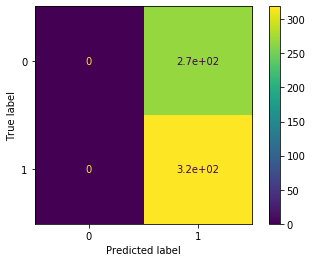

In [90]:
y_pred_xgb3 = clf_bsearch_xgb3.predict(X_test[symbol][all_features])
print('F1 Score: ', f1_score(y_pred_xgb3, y_test[symbol][f'signal_{n1}']))
print(classification_report(y_pred_xgb3, y_test[symbol][f'signal_{n1}']))
plot_confusion_matrix(
    clf_bsearch_xgb3,
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n1}']
)



In [91]:
calc_returns(y_pred_xgb3, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,1,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,1,0.006284,0.006284
2017-07-13 00:00:00+00:00,-0.016834,1,-0.010550,-0.010550
2017-07-14 00:00:00+00:00,0.002486,1,-0.008064,-0.008064
2017-07-17 00:00:00+00:00,0.002479,1,-0.005585,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.105152,0.105152
2019-11-01 00:00:00+00:00,0.011951,1,0.117103,0.117103
2019-11-04 00:00:00+00:00,-0.001540,1,0.115563,0.115563


In [ ]:
# precision_score as scoring metric

In [92]:
model = XGBClassifier
bsearch_xgb4, clf_bsearch_xgb4, params_bsearch_xgb4 = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][all_features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='precision_score'
)

  1%|          | 1/100 [00:00<00:20,  4.87it/s, best loss: -0.24727272727272726]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  2%|▏         | 2/100 [00:00<00:27,  3.54it/s, best loss: -0.6924682632585589] 

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  3%|▎         | 3/100 [00:01<00:33,  2.92it/s, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  4%|▍         | 4/100 [00:02<00:50,  1.90it/s, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  5%|▌         | 5/100 [00:03<01:02,  1.52it/s, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  6%|▌         | 6/100 [00:04<01:12,  1.30it/s, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



  8%|▊         | 8/100 [00:04<00:48,  1.90it/s, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 10%|█         | 10/100 [00:05<00:48,  1.86it/s, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 11%|█         | 11/100 [00:06<00:46,  1.92it/s, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 16%|█▌        | 16/100 [00:11<01:30,  1.08s/it, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 19%|█▉        | 19/100 [01:10<24:14, 17.96s/it, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 23%|██▎       | 23/100 [01:12<05:50,  4.56s/it, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 26%|██▌       | 26/100 [01:12<02:07,  1.73s/it, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 28%|██▊       | 28/100 [01:13<01:13,  1.02s/it, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 30%|███       | 30/100 [01:14<00:50,  1.40it/s, best loss: -0.6924682632585589]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 32%|███▏      | 32/100 [01:15<00:40,  1.67it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 34%|███▍      | 34/100 [01:16<00:37,  1.77it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 35%|███▌      | 35/100 [01:17<00:35,  1.84it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 38%|███▊      | 38/100 [01:19<00:47,  1.30it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 39%|███▉      | 39/100 [01:19<00:41,  1.47it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 41%|████      | 41/100 [01:20<00:34,  1.70it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 46%|████▌     | 46/100 [01:24<00:37,  1.46it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 51%|█████     | 51/100 [01:31<00:42,  1.15it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 53%|█████▎    | 53/100 [01:33<00:40,  1.17it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 54%|█████▍    | 54/100 [01:33<00:34,  1.35it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 58%|█████▊    | 58/100 [01:36<00:26,  1.57it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 62%|██████▏   | 62/100 [01:37<00:19,  1.97it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 63%|██████▎   | 63/100 [01:38<00:18,  2.01it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 64%|██████▍   | 64/100 [01:38<00:17,  2.02it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 70%|███████   | 70/100 [01:41<00:14,  2.12it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 72%|███████▏  | 72/100 [01:42<00:12,  2.30it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 74%|███████▍  | 74/100 [01:44<00:15,  1.68it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 76%|███████▌  | 76/100 [01:44<00:10,  2.18it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 77%|███████▋  | 77/100 [01:45<00:10,  2.17it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 80%|████████  | 80/100 [01:47<00:13,  1.52it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 82%|████████▏ | 82/100 [01:49<00:12,  1.48it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 84%|████████▍ | 84/100 [01:50<00:10,  1.46it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 85%|████████▌ | 85/100 [01:51<00:08,  1.67it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/

 86%|████████▌ | 86/100 [01:51<00:07,  1.75it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 87%|████████▋ | 87/100 [01:51<00:05,  2.19it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 90%|█████████ | 90/100 [01:56<00:09,  1.03it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 91%|█████████ | 91/100 [01:57<00:07,  1.19it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 94%|█████████▍| 94/100 [01:58<00:03,  1.65it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 96%|█████████▌| 96/100 [02:00<00:02,  1.47it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 97%|█████████▋| 97/100 [02:00<00:01,  1.61it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 99%|█████████▉| 99/100 [02:01<00:00,  2.14it/s, best loss: -0.7146813186813187]

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

//anaconda3/envs/capstone_nf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



100%|██████████| 100/100 [02:01<00:00,  1.22s/it, best loss: -0.7929195804195804]
##### Results #####
Score best parameters:  -0.7929195804195804
Best parameters:  {'C': 100.23256909691997, 'cv': 'tscv', 'gamma': 3.503852760179584e-05, 'max_samples': 0.8407965706183376, 'model': <class 'sklearn.svm._classes.SVC'>, 'normalize': 1, 'scale': 0}
Test Score (accuracy):  0.5366269165247018
Parameter combinations evaluated:  100
Time elapsed:  122.10973715782166


Precision Score:  0.5424982530220307
              precision    recall  f1-score   support

           0       0.45      0.49      0.47       246
           1       0.61      0.57      0.59       341

    accuracy                           0.54       587
   macro avg       0.53      0.53      0.53       587
weighted avg       0.54      0.54      0.54       587



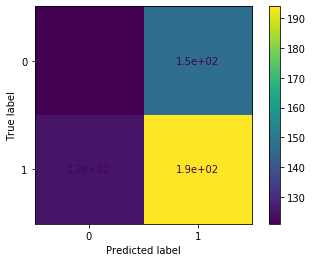

In [97]:
y_pred_xgb4 = clf_bsearch_xgb4.predict(X_test[symbol][all_features])
print('Precision Score: ', precision_score(y_pred_xgb4, y_test[symbol][f'signal_{n1}'], average='weighted'))
print(classification_report(y_pred_xgb4, y_test[symbol][f'signal_{n1}']))
plot_confusion_matrix(
    clf_bsearch_xgb4,
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n1}']
)


In [98]:
calc_returns(y_pred_xgb4, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,1,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,1,0.006284,0.006284
2017-07-13 00:00:00+00:00,-0.016834,1,-0.010550,-0.010550
2017-07-14 00:00:00+00:00,0.002486,1,-0.008064,-0.008064
2017-07-17 00:00:00+00:00,0.002479,1,-0.005585,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.105152,0.105152
2019-11-01 00:00:00+00:00,0.011951,1,0.117103,0.117103
2019-11-04 00:00:00+00:00,-0.001540,1,0.115563,0.115563


## Running on all 50 stocks on best model

In [ ]:
#best_params = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 218, 'max_features': 1, 'min_samples_leaf': 19, 'n_estimators': 423}
#model_2a = (n_jobs=-1, **params_rf4)
avg_results, scores_dict, preds_dict, params_dict, returns_dict = avg_model(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,
    ti_list,
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=clf_rf4,
    silent = False
)

'Leg [49/50]; Elapsed Time 2813.0s\n'

,3,5,7,10,15,20,25,30
1,0.505093,0.500817,0.50106,0.50193,0.499392,0.501617,0.499809,0.500921
3,0.503007,0.507944,0.504954,0.502903,0.50259,0.507145,0.50193,0.501373
5,0.504363,0.505302,0.511421,0.514411,0.51003,0.508396,0.508779,0.514376
7,0.505789,0.510274,0.508918,0.505163,0.512881,0.512951,0.509822,0.516566
10,0.509404,0.513855,0.510934,0.508605,0.514063,0.512221,0.517262,0.513716
15,0.515975,0.51236,0.516984,0.512638,0.517227,0.522824,0.516879,0.512916
20,0.518722,0.515523,0.515941,0.512846,0.517748,0.516532,0.512881,0.513437
25,0.519452,0.514619,0.517888,0.518374,0.516601,0.512707,0.507631,0.510552
30,0.522025,0.518096,0.518166,0.518722,0.519278,0.515489,0.516149,0.521434


In [ ]:
#best_params = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 218, 'max_features': 1, 'min_samples_leaf': 19, 'n_estimators': 423}
#model_2a = (n_jobs=-1, **params_rf4)
avg_results, scores_dict, preds_dict, params_dict, returns_dict = avg_model(
    symbol_list,
    forecast_horizon,                                 
    input_window_size,
    ti_list,
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=RandomForestClassifier,
    silent = False,
    hyper_optimize=True,
    n_eval=10,
)